<a href="https://colab.research.google.com/github/ahn9807/DnCNN/blob/main/DnCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import os
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)

if device == 'cuda':
    torch.cuda.manual_seed_all(0)

In [9]:
learning_rate = 0.001
training_epochs = 8
batch_size = 10

In [10]:
import os

import random
import glob
import io
import numpy as np
import PIL.Image as pil_image


class Dataset(object):
    def __init__(self, images_dir, patch_size,
                 sigma):
        self.image_files = sorted(glob.glob(images_dir + '/*'))
        self.patch_size = patch_size
        self.sigma= sigma


    def __getitem__(self, idx):
        clean_image = pil_image.open(self.image_files[idx]).convert('L')

        crop_x = random.randint(0, clean_image.width - self.patch_size)
        crop_y = random.randint(0, clean_image.height - self.patch_size)
        clean_image = clean_image.crop((crop_x, crop_y, crop_x + self.patch_size, crop_y + self.patch_size))

        noisy_image = clean_image.copy()

        gaussian_noise = np.random.normal(0.0, self.sigma, (clean_image.height, clean_image.width)).astype(np.float32)

        clean_image = np.array(clean_image).astype(np.float32)
        noisy_image = np.array(noisy_image).astype(np.float32)
        noisy_image += np.array(gaussian_noise)

        input = noisy_image[None, :, :] / 255.0
        label = clean_image[None, :, :] /255.0

        return input, label

    def __len__(self):
        return len(self.image_files)

In [11]:
train_data = Dataset('/content/drive/MyDrive/DnCNN/testsets/BSD68', patch_size=250, sigma=15)
test_data = Dataset('/content/drive/MyDrive/DnCNN/testsets/Set12', patch_size=250,  sigma=15)

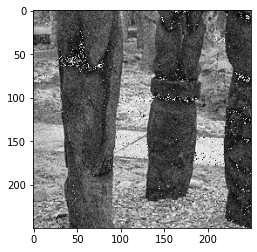

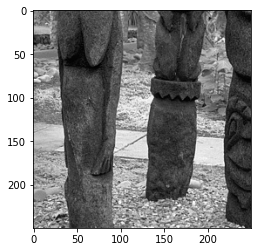

In [12]:
train_set = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size)

test_set = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

dataiter = iter(train_set)
images, labels = dataiter.next()
plt.figure()
plt.imshow(transforms.ToPILImage()(images[0]), cmap='gray')
plt.figure()
plt.imshow(transforms.ToPILImage()(labels[0]), cmap='gray')

In [13]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(),
        )

        self.innerLayer = torch.nn.Sequential(
            torch.nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64,1,kernel_size=3, stride=1,padding=1),
        )

    def forward(self, x):
        y = x
        out = self.layer1(x)
        for i in range(17):
            out = self.innerLayer(out)
        out = self.layer3(out)
        return y - out

In [14]:
model = CNN().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(train_set)
print('총 배치의 수 :  {}'.format(total_batch))

총 배치의 수 :  7


In [15]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in train_set:
        X = X.to(device)
        Y = Y.to(device)

        hypothesis = model(X)
        cost = criterion(hypothesis, X - Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.103934661
[Epoch:    2] cost = 0.0236327369
[Epoch:    3] cost = 0.0155606512
[Epoch:    4] cost = 0.0142197665
[Epoch:    5] cost = 0.0106678577
[Epoch:    6] cost = 0.013058031
[Epoch:    7] cost = 0.010621462
[Epoch:    8] cost = 0.0104038771


In [16]:
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.cuda()
        label = label.cuda()

        #plt.imshow(transforms.ToPILImage()(imgs[0]), cmap='gray')

        prediction = model(imgs)
        correct_prediction = criterion(imgs, label)
        accuracy = correct_prediction.float().mean()
        print('Accuracy:', accuracy.item())

        break;

Accuracy: 0.0034541820641607046


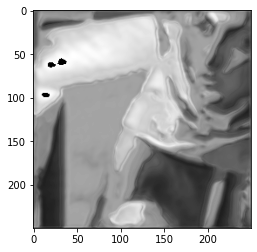

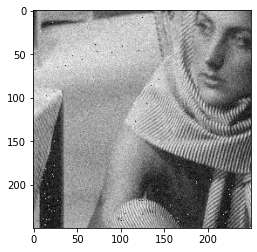

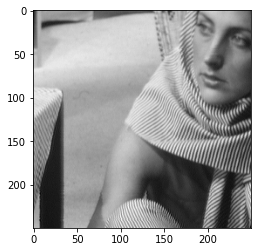

In [17]:
plt.figure()
index = 0
plt.imshow(transforms.ToPILImage()(imgs[index]-prediction[index]), cmap='gray')
plt.figure()
plt.imshow(transforms.ToPILImage()(imgs[index]), cmap='gray')
plt.figure()
plt.imshow(transforms.ToPILImage()(label[index]), cmap='gray')